In [ ]:
'''
data = [['The', 'King', 'James', 'Bible'], 
        ['The', 'Old', 'Testament', 'of', 'the', 'King', 'James', 'Bible'], 
        ['The', 'First', 'Book', 'of', 'Moses', ':', 'Called', 'Genesis'], 
        ['In', 'the', 'beginning', 'God', 'created', 'the', 'heaven', 'and', 'the', 'earth'], 
        ['And', 'the', 'earth', 'was', 'without', 'form', ',', 'and', 'void', ';', 'and', 'darkness', 'was', 'upon', 'the', 'face', 'of', 'the', 'deep', '.'], 
        ['And', 'the', 'Spirit', 'of', 'God', 'moved', 'upon', 'the', 'face', 'of', 'the', 'waters', '.'], 
        ['And', 'God', 'said', ',', 'Let', 'there', 'be', 'light', ':', 'and', 'there', 'was', 'light', '.'], 
        ['And', 'God', 'saw', 'the', 'light', ',', 'that', 'it', 'was', 'good', ':', 'and', 'God', 'divided', 'the', 'light', 'from', 'the', 'darkness', '.'], 
        ['And', 'God', 'called', 'the', 'light', 'Day', ',', 'and', 'the', 'darkness', 'he', 'called', 'Night', '.'], 
        ['And', 'the', 'evening', 'and', 'the', 'morning', 'were', 'the', 'first', 'day', '.']]

In [3]:
from nltk.corpus import gutenberg
from tensorflow.keras.preprocessing import text
from tensorflow.keras.preprocessing import text
from tensorflow.keras.preprocessing import sequence

sdff = [['The', 'King', 'James', 'Bible'],
        ['The', 'First', 'Book', 'of', 'Moses', 'Called', 'Genesis']]

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(sdff)
word2id = tokenizer.word_index

word2id.items()

id2word = {v:k for k, v in word2id.items()}

wids = [[word2id[y.lower()] for y in x] for x in sdff]

print(wids)
vocab_size = len(word2id)
print("vocab_size ={0}".format(vocab_size))
print('Vocabulary Sample:', list(word2id.items()))

[[1, 2, 3, 4], [1, 5, 6, 7, 8, 9, 10]]
vocab_size =10
Vocabulary Sample: [('the', 1), ('king', 2), ('james', 3), ('bible', 4), ('first', 5), ('book', 6), ('of', 7), ('moses', 8), ('called', 9), ('genesis', 10)]


In [4]:
# Build the corpus vocabulary

from tensorflow.keras.preprocessing import text

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(sdff)

word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

vocab_size = len(word2id) + 1 
embed_size = 100

wids= [[word2id[y.lower()] for y in x] for x in sdff]
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 11
Vocabulary Sample: [('the', 1), ('king', 2), ('james', 3), ('bible', 4), ('first', 5), ('book', 6), ('of', 7), ('moses', 8), ('called', 9), ('genesis', 10)]


In [5]:
# Build a skip-gram [(target, context), relevancy] generators

# - (word, word in the same window), with label 1 (positive samples).
# - (word, random word from the vocabulary), with label 0 (negative samples).

from tensorflow.keras.preprocessing.sequence import skipgrams

# generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(james (3), genesis (10)) -> 0
(james (3), bible (4)) -> 1
(king (2), book (6)) -> 0
(king (2), james (3)) -> 1
(king (2), bible (4)) -> 1
(the (1), bible (4)) -> 1
(bible (4), the (1)) -> 1
(bible (4), james (3)) -> 1
(james (3), the (1)) -> 1
(king (2), james (3)) -> 0


In [6]:
# Build the skip-gram model architecture

import numpy as np
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dense, Reshape
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Model

In [7]:
# Define Two sets of Image
inputA = Input(shape = (1,))
inputB = Input(shape = (1,))


# the first branch operates on the first input
x1 = Embedding(vocab_size, embed_size,embeddings_initializer="glorot_uniform")(inputA)
x1 = Reshape((embed_size, ))(x1)
x1 = Model(inputs=inputA, outputs=x1)

# the second branch opreates on the second input
x2 = Embedding(vocab_size, embed_size,embeddings_initializer="glorot_uniform")(inputB)
x2 = Reshape((embed_size,))(x2)
x2 = Model(inputs=inputB, outputs=x2)

# combine the output of the two branches
combined = concatenate([x1.output, x2.output])

# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(1, kernel_initializer="glorot_uniform",activation="sigmoid")(combined)

# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x1.input, x2.input], outputs=z)

model.summary()

model.compile(loss="mean_squared_error", optimizer="rmsprop")

# view model summary
print(model.summary())

# visualize model structure
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

# model_to_dot(model, show_shapes=True, show_layer_names=False, rankdir='TB')

for epoch in range(1, 6):
    loss = 0
    for i, elem in enumerate(skip_grams):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        if i % 10000 == 0:
            print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
        loss += model.train_on_batch(X,Y)  

    print('Epoch:', epoch, 'Loss:', loss)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       1100        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       1100        input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
# https://www.kdnuggets.com/2018/04/implementing-deep-learning-methods-feature-engineering-text-data-skip-gram.html

In [28]:
embed_layer_weights = model.get_layer('embedding_1').get_weights()[0][1:]

print(embed_layer_weights.shape)

import pandas as pd

df = pd.DataFrame(embed_layer_weights, index=id2word.values()).head().T

df

(10, 100)


,the,king,james,bible,first
0,0.123286,0.226532,0.027768,0.131940,-0.003307
1,0.022101,-0.226642,-0.030477,0.195855,0.196451
2,-0.208757,0.102711,-0.121820,-0.011726,0.184570
3,0.013072,0.035796,0.055008,-0.195515,0.234745
4,-0.152177,0.031311,-0.126345,0.115843,0.175388
...,...,...,...,...,...
95,0.181966,0.068975,-0.171424,0.041691,-0.049449
96,0.019837,-0.163700,-0.152337,-0.097319,-0.089524
97,0.085056,0.045612,-0.039000,-0.070202,0.080994
98,-0.107047,0.001192,0.132917,-0.001371,0.168162


In [32]:
seneten = 'the'



array([ 0.12328565,  0.02210053, -0.20875722,  0.01307229, -0.1521767 ,
       -0.24242339, -0.07706003,  0.19345967,  0.1767865 ,  0.1290968 ,
        0.17328714, -0.00236644, -0.03918898,  0.09456581,  0.1327328 ,
        0.21905482, -0.2029304 , -0.02875277,  0.07935661,  0.18367337,
       -0.18560782, -0.04930238, -0.139519  ,  0.22684693, -0.17525063,
        0.19498321,  0.23099068, -0.11924646, -0.06498007,  0.0048749 ,
       -0.06942524, -0.04754084,  0.18031433,  0.05124881,  0.21463886,
       -0.05357247, -0.08549824, -0.06013143,  0.05521685, -0.05813576,
       -0.06586694,  0.14669493, -0.17053379, -0.09111465,  0.23243658,
        0.07134292,  0.19292793, -0.07645305,  0.06962932, -0.12814562,
       -0.0298083 , -0.09485845, -0.05009864,  0.07699689, -0.10205524,
       -0.23190635, -0.12969269,  0.11704001,  0.06302093,  0.09081487,
        0.11008994,  0.04399976, -0.21099812,  0.18399477,  0.06157643,
        0.0285271 ,  0.00470413, -0.1122279 ,  0.03737529, -0.04

In [42]:
from sklearn.metrics.pairwise import euclidean_distances

distance_matrix = euclidean_distances(embed_layer_weights)

print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['king','bible', 'james']}

similar_words

(10, 10)


{'king': ['james', 'book', 'the', 'genesis', 'moses'],
 'bible': ['king', 'first', 'the', 'moses', 'of'],
 'james': ['king', 'the', 'of', 'moses', 'called']}

In [47]:
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

sentences = [["james", "first", "king"]]

tokens = []
labels = []

for sentence in sentences:
    for word in sentence:
        tokens.append(df[word].values)
        labels.append(word)

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)

x = []
y = []

for value in new_values:
    x.append(value[0])
    y.append(value[1])

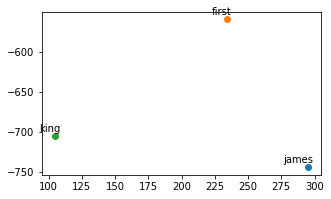

In [48]:
    
plt.figure(figsize=(5, 3)) 

for i in range(len(x)):
    plt.scatter(x[i],y[i])
    
    plt.annotate(labels[i], xy=(x[i], y[i]), xytext=(5, 2),textcoords='offset points',ha='right', va='bottom')

plt.show()